
========== DIABETE_RISQUE ==========
Effectifs des classes : {0: np.int64(75), 1: np.int64(45)}
Classification report :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.89      0.94         9

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24

Matrice de confusion :
[[15  0]
 [ 1  8]]
AUC ROC : 0.91


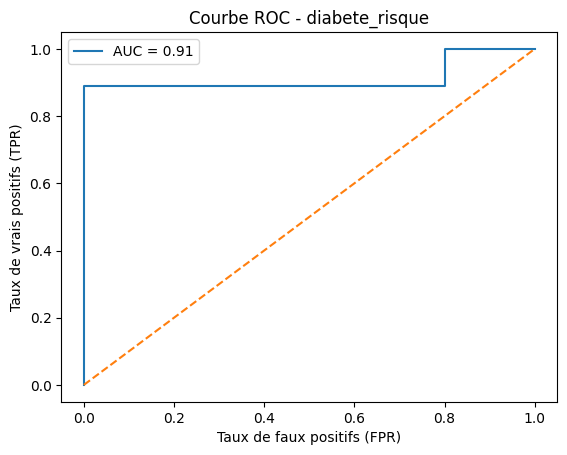

Probabilité d'être à risque (diabete) pour ce profil : 16.0%

========== OBESITE_RISQUE ==========
Effectifs des classes : {1: np.int64(60), 0: np.int64(60)}
Classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Matrice de confusion :
[[12  0]
 [ 0 12]]
AUC ROC : 1.00


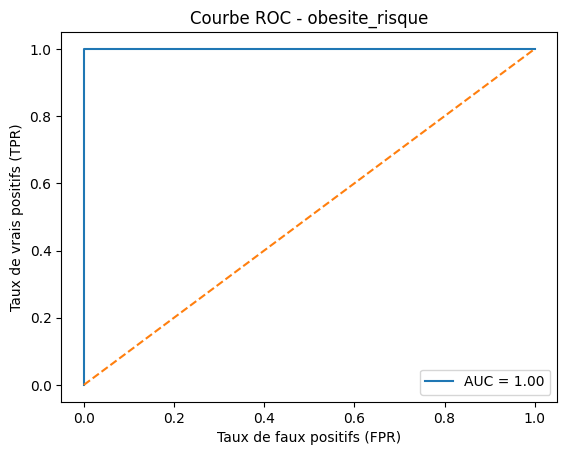

Probabilité d'être à risque (obesite) pour ce profil : 35.0%

========== MCV_RISQUE ==========
Effectifs des classes : {0: np.int64(60), 1: np.int64(60)}
Classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Matrice de confusion :
[[12  0]
 [ 0 12]]
AUC ROC : 1.00


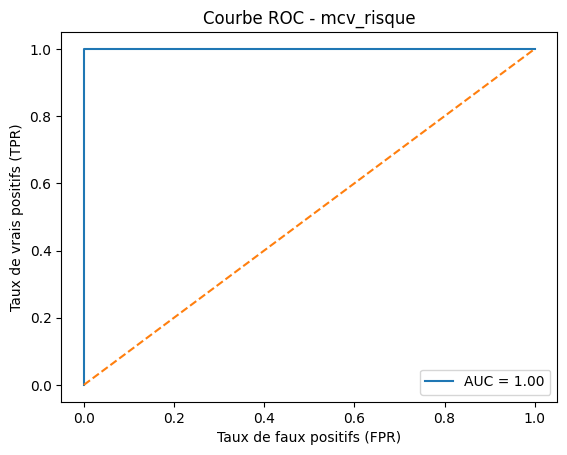

Probabilité d'être à risque (mcv) pour ce profil : 73.0%

========== CANCERCOLORECTAL_RISQUE ==========
Effectifs des classes : {0: np.int64(60), 1: np.int64(60)}
Classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Matrice de confusion :
[[12  0]
 [ 0 12]]
AUC ROC : 1.00


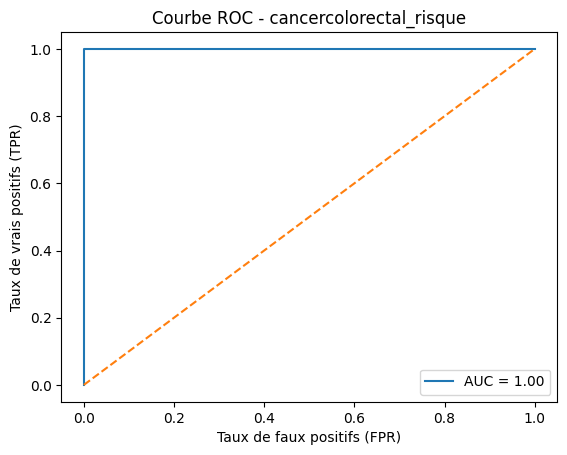

Probabilité d'être à risque (cancercolorectal) pour ce profil : 73.0%

Analyse ML terminée pour toutes les maladies (seuils adaptés).


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_csv('/content/france_nutrition_sante_fusionfinal.csv')  # Mets ton chemin ici

# 2. Seuils adaptés pour garantir les deux classes (ajuste si besoin)
seuils = {
    'diabete_prev': 2.8,             # 75e percentile ≈ 2.825, ici seuil à 2.8
    'obesite_prev': 10.2,            # 75e percentile ≈ 10.45, ici seuil à 10.2
    'mcv_mort_rate': 280,            # adapte selon ta distribution réelle
    'cancercolorectal_inc': 28.0     # 75e percentile ≈ 28.8, ici seuil à 28.0
}

# 3. Préparation des cibles binaires
maladies = {
    "diabete_risque": (df['diabete_prev'] >= seuils['diabete_prev']).astype(int),
    "obesite_risque": (df['obesite_prev'] >= seuils['obesite_prev']).astype(int),
    "mcv_risque": (df['mcv_mort_rate'] >= seuils['mcv_mort_rate']).astype(int),
    "cancercolorectal_risque": (df['cancercolorectal_inc'] >= seuils['cancercolorectal_inc']).astype(int)
}

features = ['sodium', 'ssbs', 'fiber', 'procmeat', 'redmeat', 'fruit']

for maladie, y in maladies.items():
    print(f"\n========== {maladie.upper()} ==========")
    df_valid = df[features].join(y).dropna()
    X = df_valid[features]
    y_valid = df_valid[y.name]

    # Vérifier effectifs
    counts = y_valid.value_counts()
    print("Effectifs des classes :", dict(counts))
    if len(counts) < 2 or counts.min() < 5:
        print(f"⚠️ Impossible d’entraîner un modèle pour {maladie} : classes déséquilibrées ({dict(counts)})")
        continue

    # Split stratifié
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_valid, test_size=0.2, random_state=42, stratify=y_valid
    )

    # Entraînement
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Prédiction
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Évaluation
    print("Classification report :")
    print(classification_report(y_test, y_pred))
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC ROC : {auc:.2f}")

    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title(f"Courbe ROC - {maladie}")
    plt.legend()
    plt.show()

    # Exemple prédiction personnalisée
    user_data = {
        'sodium': 2.8, 'ssbs': 100, 'fiber': 8, 'procmeat': 30, 'redmeat': 90, 'fruit': 80
    }
    user_df = pd.DataFrame([user_data])
    user_proba = clf.predict_proba(user_df)[0][1]
    print(f"Probabilité d'être à risque ({maladie.replace('_risque','')}) pour ce profil : {user_proba*100:.1f}%")

print("\nAnalyse ML terminée pour toutes les maladies (seuils adaptés).")


